In [69]:
# import libs
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.style.use("bmh")

$x$, $t$ -> $u$

In [2]:
# NN def
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20), # x & t -> 20 neurons
            nn.Tanh(), # activation funct.
            nn.Linear(20, 30), #20 neurons -> 30 neurons
            nn.Tanh(), #act, funct
            nn.Linear(30, 30), #30-> 20
            nn.Tanh(), #af
            nn.Linear(30, 20), # 30 ->20
            nn.Tanh(), #af
            nn.Linear(20, 20), # 20 -> 20
            nn.Tanh(), #af
            nn.Linear(20, 1), # 20 -> 1
        )
        
    def forward(self, x):
        out = self.net(x)
        return out

In [54]:
# data = ICs & BCs
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        self.model = NN().to(device)
        
        # comp. domain 
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T # first spatial element
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T # last spatial element
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T # initial cond
        self.X_train = torch.cat([bc1, bc2, ic])
        
        y_bc1 = torch.zeros(len(bc1)) # u at the bc1
        y_bc2 = torch.zeros(len(bc2)) # u at the bc2 
        y_ic  = -torch.sin(np.pi * ic[:,0]) # u at the ic
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True
        
        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
    
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred,self.y_train)
        
        u = self.model(self.X)
        
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]
        
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dxx = du_dXX[:,0]
        
        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01/np.pi) * du_dxx)
        
        loss = loss_pde + loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1
        
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

In [55]:
# training 
net = Net()
net.train()

100 0.17510460317134857
200 0.0908498466014862
300 0.08486726880073547
400 0.07067061960697174
500 0.05853155255317688
600 0.03806963562965393
700 0.028300028294324875
800 0.020984653383493423
900 0.018737567588686943
1000 0.015604401007294655
1100 0.009257214143872261
1200 0.005572706926614046
1300 0.0035864063538610935
1400 0.002330436836928129
1500 0.001780154649168253
1600 0.0012784996069967747
1700 0.0009121198090724647
1800 0.0006985213840380311
1900 0.0005351263680495322
2000 0.00043779134284704924
2100 0.00036645669024437666
2200 0.000310835603158921
2300 0.00028132935403846204
2400 0.00024010126071516424
2500 0.00021281509543769062
2600 0.0001887689286377281
2700 0.00020396735635586083
2800 0.00014456588542088866
2900 0.00013375216803979129
3000 0.0001229935442097485
3100 0.00011684994387906045
3200 0.00010370863310527056
3300 9.733696060720831e-05
3400 9.1076573880855e-05
3500 8.210435771616176e-05
3600 7.506206020480022e-05
3700 6.809281330788508e-05
3800 6.187257531564683e-

In [56]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [62]:
h = 0.01 # dx
k = 0.01 # dt

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [67]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x), len(t)).cpu().numpy()

In [68]:
y_pred

array([[ 0.00221291,  0.00177865,  0.00138511, ..., -0.00114535,
        -0.0011607 , -0.00117691],
       [ 0.03409311,  0.03266129,  0.03132558, ...,  0.00631441,
         0.00623935,  0.0061646 ],
       [ 0.06580745,  0.06339966,  0.06113984, ...,  0.01380356,
         0.01366903,  0.01353566],
       ...,
       [-0.09291439, -0.09037499, -0.08797626, ..., -0.02481745,
        -0.02463196, -0.02445088],
       [-0.06150334, -0.05989407, -0.05837218, ..., -0.01696394,
        -0.01683818, -0.01671605],
       [-0.02992116, -0.02925168, -0.02861612, ..., -0.00910203,
        -0.00903617, -0.00897305]], dtype=float32)

In [70]:
plt.figure(figsize=(5,3), dpi=3e3)
sns.heatmap(y_pred)

<Axes: >

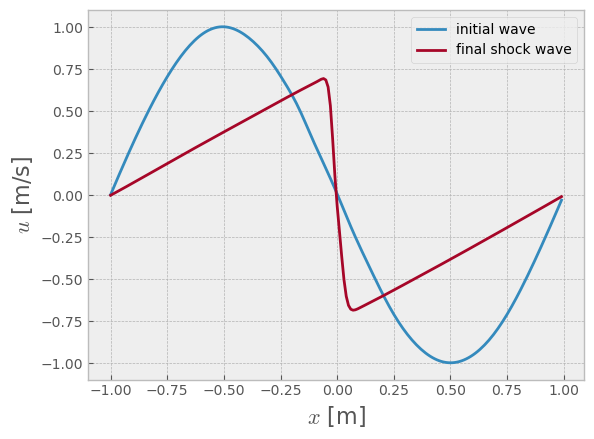

In [76]:
plt.plot(x, y_pred[:,0], label="initial wave");
plt.plot(x, y_pred[:, -1], label="final shock wave");
plt.xlabel(r"$x$ [m]", size=16);
plt.ylabel(r"$u$ [m/s]", size=16);
plt.legend();